# Reinforcement Learning for Inverted Pendulum Control

### Andrew Stirling, 260894650

## Introduction

Control theory, is centred around the behaviour of dynamic systems, and how as
engineers we can force it to behave in a certain way. In the context of Mechanical Engineering, these systems could vary from robotics, to automotive systems, to aerospace and HVAC applications. A large portion of Control design is spent modelling the system or "plant". This requires a good grasp of the system's mechanics, understanding all variables that may influence its behaviour. For complex systems, these dynamics are highly non-linear, while exhibiting large degrees of freedom. In such applications, traditional control techniques may struggle to produce reliable and accurate behaviour. Moreover, we may not even be able to model the system, making any form of controller design impossible. 

In these cases, we can make use of Reinforcement Learning (RL) for controlling such complex systems. RL operates in a model-free fashion, meaning we are not required to have an explicit model of a system's behaviour given various inputs. Using RL, we can effectively sidestep all the disadvantages of model-based controller design. RL generally consists of an agent who, through interacting with an environment, can learn to map various situations to actions. Specifically, the environment provides responses to each a agent's action, using these responses and rewards dependent on various states of the agent, we can condition the agent's decisions towards optimal states. In class, the problems we solved required the action and/or the state to be discretizable. However, for continuous systems, this may not be possible or if it is, it raises the question to what resolution we look to discretize the space or actions. The Soft Actor-Critic architecture is a form of RL that looks to solve this problem. 

In this project, we look to investigate RL's applications and performance in control settings. Specifically, we look to investigate the Soft Actor-Critic (SAC) architecture's ability to control a continuous system, consisting of an inverted pendulum on a cart. 


### The Inverted Pendulum

The inverted problem is a "classic" problem in Control Theory. In this experiment, we have a pendulum or pole on top of a cart, which can move side to side. The goal is to keep the pendulum upright, by applying varied forces to the cart. The Farama-Foundation provides the "gymnasium" environment [1] (formerly maintained by OpenAI), which allows us to test various RL architectures applied to this problem. Pre-defined in this environment [2] is a continuous action space in the range [-3, 3] N, which represents the amount of force we can apply to the cart. Similarly, the observations space consists of 4 states represented as an ndarry with shape 4 holding the position of the cart along the slider, vertical angle of the pole on the cart, linear velocity of the cart, and angular velocity of the pole on the cart, respectively. All values can be in the range of [-Inf, Inf]. The reward is +1 for every timestep that the pole is upright. To get a sense of how the pendulum acts, we can start with random actions to see how it responds. The episode ends when either the episode duration reaches 1000 timesteps, any of the state space values are no longer finite, or the vertical angle of the pendulum drops to below 90 degrees (even with the cart). To get a sense of the system, we can display the response of the pendulum to random actions as seen below. 


In [14]:
from IPython.display import HTML, Image
HTML("""
<center>
    <video width="720" height="540" controls>
        <source src="vids/no_control.mp4" type="video/mp4">
    </video>
</center>
""")

As can be seen above, the pendulum falls down nearly immediately ending the episode as soon as it reaches the horizontal position of the cart. 

Now, as mentioned previously, both the action and observation states are continuous. Discretizing these is possible, but to what amount is unclear and we are unsure if this method would provide stable control. Currently, a common method around this is the Soft Actor-Critic (SAC) architecture, which we will introduce in detail. 

### Soft Actor-Critic Architecture

To begin, we must first introduce new concepts not covered in class. The first of these is the state action value function $Q^\pi(s,a)$. As opposed to the state value function $V^\pi(s)$, $Q^\pi(s,a)$ takes into account the current action $a$ as well as the current state $s$, then evaluates the expected return, following the policy $\pi$. A second concept that we must introduce is entropy. As opposed to the entropy mechanical engineers study in thermodynamics, entropy in probability, deals with how random a random variable is [3]. We can write the entropy $H$ of the random variable $X$, computed from its distribution $P$ as

$$
H(P) = \underset{{X \sim P}}{\mathbf{E}}[-logP(X)] \tag{1}
$$

Now that we have introduced these two concepts, we can begin discussing the SAC algorithm. SAC optimizes a stochastic policy in an off-policy way. In other words, it is not deterministic, thus there's some randomness in decision making. Moreover, in off-policy learning, the state action value function $Q^\pi(s,a)$ is learned from taking actions determined by following the policy. Using the expression for entropy shown previously, we can rewrite the $Q$ function as 

$$
Q^\pi(s,a) = \underset{{\tau \sim \pi}}{\mathbf{E}}[\sum_{t=0}^{\infty}\gamma^t(R(s_t,a_t,s_{t+1})+\alpha H(\pi(\cdot|s_t)))|s_0 = s] 
$$

The Bellmann equation for $Q$ is thus

$$
Q^{\pi*}(s,a) = \underset{a' \sim \pi}{\underset{{s'\sim P}}{\mathbf{E}}}[(R(s,a_t,s')+\gamma (Q^{\pi}(s',a'))+\alpha H(\pi(\cdot|s')))] \tag{2}
$$

The right-hand side is an an expected value over next states. These next states come from the replay buffer, and the next actions come from the current policy. As Equ. (2) is an expression for expected value, we can approximate it through sampling as

$$
Q^{\pi*}(s,a) \approx r + \gamma (Q^{\pi}(s',a') + \alpha H(\pi(\cdot|s'))) \tag{3}
$$

Then using Equ. (1) for entropy, we can simplify the above again as 
$$
Q^{\pi*}(s,a) \approx r + \gamma (Q^{\pi}(s',a') - \alpha log \pi(\bar{a}'|s')), \quad \bar{a}' \sim \pi(\cdot|s') \tag{4}
$$
SAC concurrently learns a policy $\pi_\theta$ and two Q-functions, $Q_{\phi_1}, Q_{\phi_2}$. In this implementation of the SAC algorithm, we opt to use a fixed entropy regularization coefficient $\alpha$, however other implementations use a varying $\alpha$ over the course of training [3]. Fixing $\alpha$ was much simpler, and still provided good results, so we did not consider the varying method.

In SAC, as its use is for continuous states, the goal is to train a Q-network. This helps to approximate the continuous action state value function $Q$ [4]. The Q-network is trained using a loss function given as

$$
L(\phi_i, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathbf{E}}}\left[( Q_{\phi_i}(s,a) - y(r,s',d))^2\right] \tag{5}
$$

Where the $Q_{\phi_i}$ function is calculated using the sample approximation from Equ. (4). The target y(r,s',d) is computed through taking the minimum Q-value between the two Q approximations. This is known as the clipped double-Q trick [5], which allows for the calculation of the target as

$$
y(r, s', d) = r + \gamma (1 - d) \left( \min_{j=1,2} Q_{\phi_{\text{targ},j}}(s', \bar{a}') - \alpha \log \pi_{\theta}(\bar{a}'|s') \right), \quad \bar{a}' \sim \pi_{\theta}(\cdot|s') \tag{6}
$$

To learn the policy, we use the fact that in each state, the policy should act the maximize the expected future return plus expected future entropy. In other words, it should maximize $V^\pi(s)$, which is calculated through

$$
\begin{align*}
V^{\pi}(s) &= \underset{a \sim \pi}{\mathbf{E}}{Q^{\pi}(s,a)} + \alpha H\left(\pi(\cdot|s)\right) \\
&= \underset{a \sim \pi}{\mathbf{E}}{Q^{\pi}(s,a) - \alpha \log \pi(a|s)} \tag{7}
\end{align*}
$$

As outlined previously, the policy is non deterministic. To optimize the policy, SAC uses the reparameterization trick, where we sample $\pi_\theta(\cdot|s)$ through computng a deterministic function of state, policy parameters, and independent noise. In this implementation, we follow a squashed Gaussian policy, which means that samples are obtained using

$$
\tilde{a}_{\theta}(s, \xi) = \tanh\left( \mu_{\theta}(s) + \sigma_{\theta}(s) \odot \xi \right), \quad \xi \sim \mathcal{N}(0, I) \tag{8}
$$

The squashing function helps ensure that actions are bound to a finite range, and don't drift to infinity to exploit the policy. The reparemetrization allows us to rewrite the expected value of the actions. This is useful as the distribution depended on the policy parameters, making it difficult to compute and made associated gradients non-deterministic, creating high variance in the updates [4]. Rewriting the expected value using the sampled noise $\xi$ from $\mathcal{N}$, allows the sampling operation to be moved outside the gradient flow during backpropagation, making optimization more stable. 

To get the policy loss, we must substitute $Q^{\pi_\theta}$ with our function approximators. SAC uses the clipped double-Q trick from Equ. (6), allowing us to optimize the policy using 
$$
\max_{\theta} \underset{s \sim \mathcal{D}}{\underset{\xi \sim \mathcal{N}}{E}}[{\min_{j=1,2} Q_{\phi_j}(s,\tilde{a}_{\theta}(s,\xi)) - \alpha \log \pi_{\theta}(\tilde{a}_{\theta}(s,\xi)|s)}] \tag{9}
$$

## Implementation

To summarise, SAC is an off-policy algorithm which trains a stochastic policy with entropy regularization. It learns from a replay buffer, which contains experiences collected by the agent over time from different versions of the policy. The entropy regularization coefficient $\alpha$ controls the balance between exploring new actions, and exploiting actions that provide good rewards. Higher values of $\alpha$ imply more exploration of the space. This requires careful tuning of this variable in order get large and stable rewards over time.

Additionally, on testing performance of the model, we no longer sample the action and instead use the mean action from the distribution, which improves performance during validation. We can first represent the SAC algorithm in pseudocode, provided from OpenAI's spinning up documentation [3]

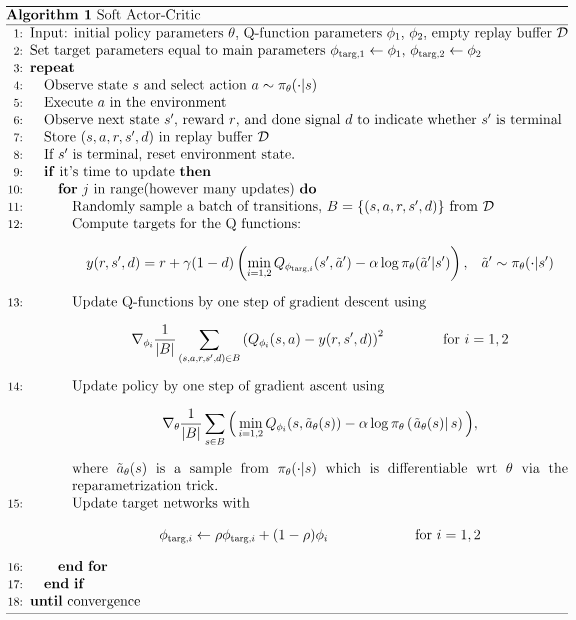

In [15]:
Image(filename = 'figs/pseudocode.PNG')

We can then code this in python, making use of the tensorflow libraries. We use the logger from OpenAI available at https://github.com/openai/spinningup/tree/master/spinup/utils. We also build upon their SAC implementation from https://github.com/haarnoja/sac/blob/master/sac/algos/sac.py, making use of their core functions from https://github.com/openai/spinningup/blob/master/spinup/algos/tf1/sac/core.py. These libraries are included along with the jupyter notebook. To run and retrain the model also requires mujoco version 2.10 which can be installed from https://github.com/google-deepmind/mujoco (use tag 2.10 for correct version). Finally, the gymnasium environment is required from https://github.com/Farama-Foundation/Gymnasium. Other dependencies are: tensorflow, numpy, scipy, mpi4py which are pip installable. The default value of $\alpha$ is set to 0.2, however we explore the influence of this coefficient later on.

```
import random
import time
import numpy as np
import tensorflow as tf
import core
from utils import logx

class ReplayBuffer:

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr, :] = obs
        self.obs2_buf[self.ptr, :] = next_obs
        self.acts_buf[self.ptr, :] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=tf.convert_to_tensor(self.obs1_buf[idxs]),
                    obs2=tf.convert_to_tensor(self.obs2_buf[idxs]),
                    acts=tf.convert_to_tensor(self.acts_buf[idxs]),
                    rews=tf.convert_to_tensor(self.rews_buf[idxs]),
                    done=tf.convert_to_tensor(self.done_buf[idxs]))

def sac(env_fn, actor_critic=core.mlp_actor_critic, ac_kwargs=None, seed=0,
        total_steps=1_000_000, log_every=10_000, replay_size=1_000_000,
        gamma=0.99, polyak=0.995, lr=0.001, alpha=0.2, batch_size=256,
        start_steps=10_000, update_after=1000, update_every=50,
        num_test_episodes=10, max_ep_len=1000, logger_kwargs=None,
        save_freq=int(1e4), save_path=None):
    
    """Soft Actor-Critic (SAC), documentation from 
    https://github.com/haarnoja/sac/blob/master/sac/algos/sac.py

    Params:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.

        actor_critic: A function which takes in placeholder 
            symbols for state, x_ph, and action, a_ph, and returns 
            the main outputs from the agents Tensorflow computation graph:

        ac_kwargs (dict): Any kwargs appropriate for the actor_critic
            function you provided to SAC.

        seed (int): Seed for random number generators.

        total_steps (int): Number of environment interactions to run and train
            the agent.

        log_every (int): Number of environment interactions that should elapse
            between dumping logs.

        replay_size (int): Maximum length of replay buffer.

        gamma (float): Discount factor. (Always between 0 and 1.)

        polyak (float): Interpolation factor in polyak averaging for target
            networks. 

        lr (float): Learning rate (used for both policy and value learning).

        alpha (float): Entropy regularization coefficient. (Equivalent to
            inverse of reward scale in the original SAC paper.)

        batch_size (int): Minibatch size for SGD.

        start_steps (int): Number of steps for uniform-random action selection,
            before running real policy. Helps exploration.

        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.

        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long
            you wait between updates, the ratio of env steps to gradient steps
            is locked to 1.

        num_test_episodes (int): Number of episodes to test the deterministic
            policy at the end of each epoch.

        max_ep_len (int): Maximum length of trajectory / episode / rollout.

        logger_kwargs (dict): Keyword args for EpochLogger.

        save_freq (int): How often (in terms of environment iterations) to save
            the current policy.

        save_path (str): The path specifying where to save the trained model.
    """
    config = locals()
    # logger code copied from https://github.com/openai/spinningup/blob/master/spinup/utils/logx.py
    logger = logx.EpochLogger(**(logger_kwargs or {}))
    logger.save_config(config)

    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    # Set dimensions of observation and action spaces

    # Give policy info on action and observation spaces
    ac_kwargs = ac_kwargs or {}
    ac_kwargs['action_space'] = env.action_space
    ac_kwargs['observation_space'] = env.observation_space

    # The experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim,
                                 size=replay_size)

    # Get actor critic
    actor, critic = actor_critic(**ac_kwargs)

    # Two critics to avoid overestimation error
    critic1 = critic
    critic2 = tf.keras.models.clone_model(critic)

    input_shape = [(None, obs_dim), (None, act_dim)]


    # Set weights for each critic
    critic1.build(input_shape)
    target_critic1 = tf.keras.models.clone_model(critic)
    target_critic1.set_weights(critic1.get_weights())

    critic2.build(input_shape)
    target_critic2 = tf.keras.models.clone_model(critic)
    target_critic2.set_weights(critic2.get_weights())

    # Create variables used by optimizer
    critic_variables = critic1.trainable_variables + critic2.trainable_variables

    # Set up optimizer to later calculate gradients
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

    # For use by tensorflow
    @tf.function
    def get_action(o, deterministic=tf.constant(False)):
        mu, pi, _ = actor(tf.expand_dims(o, 0))
        if deterministic:
            # return mean if testing
            return mu[0]
        else:
            #sample policy if non-deterministic
            return pi[0]

    # Learning step for soft-actor critic
    # Lines 12 - 15 from pseudo code
    @tf.function
    def learn_on_batch(obs1, obs2, acts, rews, done):
        with tf.GradientTape(persistent=True) as g:
            # Main outputs from computation graph.
            # Compute policy paramerters pi
            # Compute entropy, logp_pi
            _, pi, logp_pi = actor(obs1)
            q1 = critic1([obs1, acts])
            q2 = critic2([obs1, acts])

            # Compute Q-values for the current observations 
            # and actions sampled from the policy.
            q1_pi = critic1([obs1, pi])
            q2_pi = critic2([obs1, pi])

            # Get actions and log probs of actions for next states.
            _, pi_next, logp_pi_next = actor(obs2)

            # Get target for the Q functions
            # Calculated using current policy, for each critic
            target_q1 = target_critic1([obs2, pi_next])
            target_q2 = target_critic2([obs2, pi_next])

            ## SAC losses calculations
            # Get the minimum Q-value btween the two critics for the current policy
            min_q_pi = tf.minimum(q1_pi, q2_pi)
            min_target_q = tf.minimum(target_q1, target_q2)

            # Entropy-regularized Bellman backup for Q functions.
            # Using Clipped Double-Q targets.
            q_backup = tf.stop_gradient(rews + gamma * (1 - done) * (
                min_target_q - alpha * logp_pi_next))

            # Soft actor-critic losses.
            pi_loss = tf.reduce_mean(alpha * logp_pi - min_q_pi)
            q1_loss = 0.5 * tf.reduce_mean((q_backup - q1) ** 2)
            q2_loss = 0.5 * tf.reduce_mean((q_backup - q2) ** 2)
            value_loss = q1_loss + q2_loss

        # Compute gradients and do updates.
        # Get actor gradients
        actor_gradients = g.gradient(pi_loss, actor.trainable_variables)
        # Perform updates to actor network
        optimizer.apply_gradients(
            zip(actor_gradients, actor.trainable_variables))
        # Get critic gradients
        critic_gradients = g.gradient(value_loss, critic_variables)
        # Update the critic network
        optimizer.apply_gradients(
            zip(critic_gradients, critic_variables))
        # delete to free space
        del g

        # Polyak averaging for target variables
        # Used to slowly update target networks, stabilizes training
        # Step 15 of pseudocode
        # phi_target,i = \rho*\phi_targ,i + (1-\rho)\phi_i
        for v, target_v in zip(critic1.trainable_variables,
                               target_critic1.trainable_variables):
            target_v.assign(polyak * target_v + (1 - polyak) * v)
        for v, target_v in zip(critic2.trainable_variables,
                               target_critic2.trainable_variables):
            target_v.assign(polyak * target_v + (1 - polyak) * v)

        # Return Dictionary
        return dict(pi_loss=pi_loss,
                    q1_loss=q1_loss,
                    q2_loss=q2_loss,
                    q1=q1,
                    q2=q2,
                    logp_pi=logp_pi)

    def test_agent():
        for _ in range(num_test_episodes):
            o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            o = o[0]
            # test until not done, or max episode length reached
            while not (d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time
                # Perform step in the test environment
                o, r, d, d2, _ = test_env.step(
                    get_action(tf.convert_to_tensor(o), tf.constant(True)))
                ep_ret += r
                ep_len += 1
                d = d or d2
            # Add to the logger
            logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0
    o = o[0]

    # Main loop: collect experience in env and update/log each epoch.
    for t in range(total_steps):
        iter_time = time.time()

        # Until start_steps have elapsed, randomly sample actions
        # from a uniform distribution for better exploration. Afterwards,
        # use the learned policy.

        # At the beginning t<start_steps, randomly sample actions
        # This provides better exploration
        # if t>start_steps, use the learned policy
        if t > start_steps:
            a = get_action(tf.convert_to_tensor(o))
        else:
            a = env.action_space.sample()

        # Take action and step the environment
        o2, r, d, d2, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        # Ignore the "done" signal if it comes from hitting max time
        d = False if ep_len == max_ep_len else d
        d = d or d2

        # Add experience to the replay buffer
        replay_buffer.store(o, a, r, o2, d)

        # Update most recent observation
        o = o2

        # If end of trajectory
        # Reset Environment state
        # Step 8 of pseudocode
        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpLen=ep_len)
            o, ep_ret, ep_len = env.reset(), 0, 0
            o = o[0]

        # Update 
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every):
                # Randomly sample a batch of transitions
                batch = replay_buffer.sample_batch(batch_size)
                # Update parameters
                # Lines 12 - 15 of pseudocode
                results = learn_on_batch(**batch)
                logger.store(LossPi=results['pi_loss'],
                             LossQ1=results['q1_loss'],
                             LossQ2=results['q2_loss'],
                             Q1Vals=results['q1'],
                             Q2Vals=results['q2'],
                             LogPi=results['logp_pi'])

        logger.store(StepsPerSecond=(1 / (time.time() - iter_time)))

        # End of epoch wrap-up.
        if ((t + 1) % log_every == 0) or (t + 1 == total_steps):
            # Test the performance of the deterministic version of the agent.
            test_agent()

            # Log info about epoch.
            logger.log_tabular('EpRet', with_min_and_max=True)
            logger.log_tabular('TestEpRet', with_min_and_max=True)
            logger.log_tabular('EpLen', average_only=True)
            logger.log_tabular('TestEpLen', average_only=True)
            logger.log_tabular('TotalEnvInteracts', t + 1)
            logger.log_tabular('Q1Vals', with_min_and_max=True)
            logger.log_tabular('Q2Vals', with_min_and_max=True)
            logger.log_tabular('LogPi', with_min_and_max=True)
            logger.log_tabular('LossPi', average_only=True)
            logger.log_tabular('LossQ1', average_only=True)
            logger.log_tabular('LossQ2', average_only=True)

            logger.log_tabular('StepsPerSecond', average_only=True)
            logger.log_tabular('Time', time.time() - start_time)

            logger.dump_tabular()

        # Save model.
        if ((t + 1) % save_freq == 0) or (t + 1 == total_steps):
            if save_path is not None:
                tf.keras.models.save_model(actor, save_path)
```

We run sac.py in gym_train which is defined as
```
import gymnasium as gym
import tensorflow as tf

import sac

def make_env():
    return gym.make("InvertedPendulum-v4")

if __name__ == '__main__':
    save_path = './model_out'
    
    ac_kwargs = dict(hidden_sizes=[16, 16],
                     activation=tf.nn.relu)
    
    logger_kwargs = dict(output_dir = './logger_out',
                        exp_name='Watch out, Pendulum!')

    sac.sac(make_env, 
        ac_kwargs = ac_kwargs,
        total_steps = 200000,
        log_every = 2000,
        replay_size=10_000,
        start_steps=1_000,
        update_after=1_000,
        max_ep_len=200,
        logger_kwargs=logger_kwargs,
        save_freq=200_000,
        save_path=save_path)
```

## Discussion
To investigate how the SAC model trains, we can use the the logger class provided by OpenAI, in order to investigate how important model variables change throughout training periods. We plot these below to show how the SAC improves during training. 

It's at this point that we can also investigate the effect of $\alpha$ on the training and outputs. To do this we set initially $\alpha = 0.02$ and plot various training variables like the total return per episode, the $Q$-functions, and the entropy.

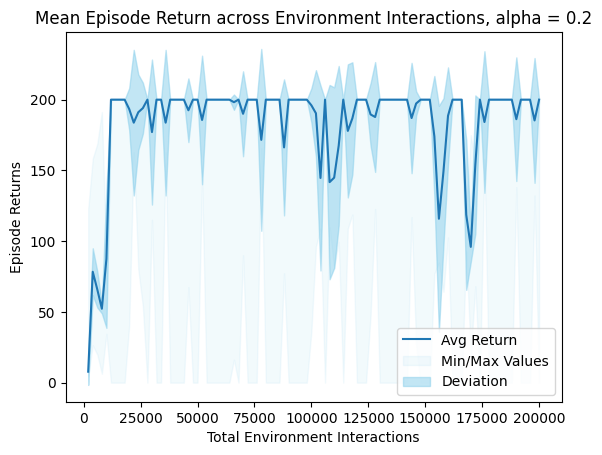

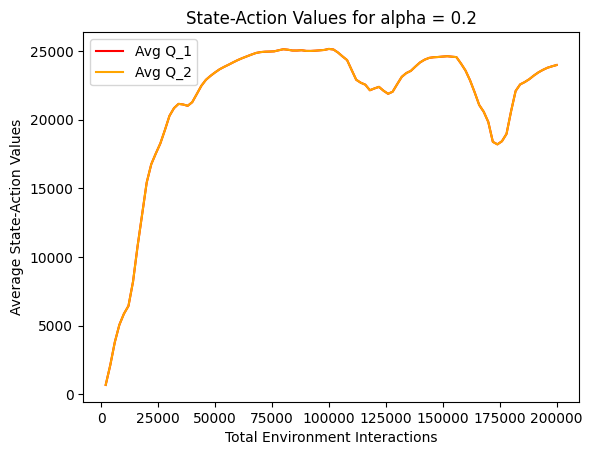

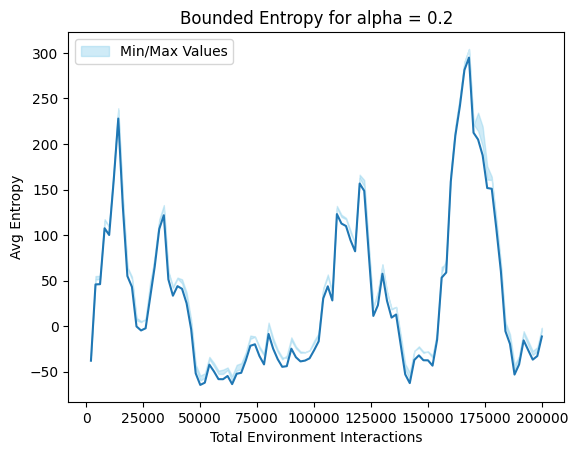

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def read_data(file_path):
    try:
        # Read the tab-separated data into a pandas DataFrame
        data = pd.read_csv(file_path, sep='\t')
        return data
    except Exception as e:
        print(f"Error reading data: {str(e)}")
        return None
    
def store_data_np(data):
    try:
        # Extract each column and convert it to a NumPy array
        columns = data.columns
        arrays = [data[col].values for col in columns]
        return arrays
    except Exception as e:
        print(f"Error extracting columns: {str(e)}")
        return None

file_path = "./logger_out_alpha_0.2/progress.txt"
data = read_data(file_path)

array_list = store_data_np(data)
avg_ep_ret = array_list[0]
std_ep_ret = array_list[1]
max_ep_ret = array_list[2]
min_ep_ret = array_list[3]

avg_test_ep_ret = array_list[4]
std_test_ep_ret = array_list[5]

avg_q1 = array_list[11]
avg_q2 = array_list[15]

avg_entropy = array_list[19]
max_entropy = array_list[21]
min_entropy = array_list[22]

total_env_reacts = array_list[10]

time = array_list[-1]

plt.plot(total_env_reacts,avg_ep_ret,label="Avg Return")
plt.fill_between(total_env_reacts,avg_ep_ret - min_ep_ret,avg_ep_ret + 200 - max_ep_ret,alpha = 0.1, color='skyblue', label = 'Min/Max Values')
plt.fill_between(total_env_reacts, avg_ep_ret - std_ep_ret,avg_ep_ret+std_ep_ret, alpha = 0.5, color='skyblue', label="Deviation")

plt.xlabel("Total Environment Interactions")
plt.ylabel("Episode Returns")
plt.title('Mean Episode Return across Environment Interactions, alpha = 0.2')
plt.legend()
plt.show()

plt.plot(total_env_reacts,avg_q1,label="Avg Q_1",color = 'red')
plt.plot(total_env_reacts,avg_q2,label = "Avg Q_2",color = "orange")
plt.xlabel("Total Environment Interactions")
plt.ylabel("Average State-Action Values")
plt.title('State-Action Values for alpha = 0.2')
plt.legend()
plt.show()

plt.plot(total_env_reacts,avg_entropy)
plt.fill_between(total_env_reacts,avg_entropy-min_entropy,avg_entropy+max_entropy,alpha = 0.4, color='skyblue', label = 'Min/Max Values')

plt.xlabel("Total Environment Interactions")
plt.ylabel("Avg Entropy")
plt.title('Bounded Entropy for alpha = 0.2')
plt.legend()
plt.show()

# for col, array in zip(data.columns, array_list):
#             print(f"{col}: {array}")

From the above 3 plots, using an $\alpha$ value of 0.2, we can see that the SAC quickly starts maxing out the reward at 200, with 200 time steps. However, due to the exploration constant, it continues to explore the space, resulting in various drops of the reward. Upon playing with this parameter, I found that any lower it would occasionally not find the optimal actions. 

From the action-state value functions and entropy relations, we can see their inverse relationship. As we increase the $Q$ values, our entropy decreases. This should be expected for the system as beneficial actions look to stabilize the system. By stabilizing the pendulum we decrease the entropy, as our system literally becomes less disordered.



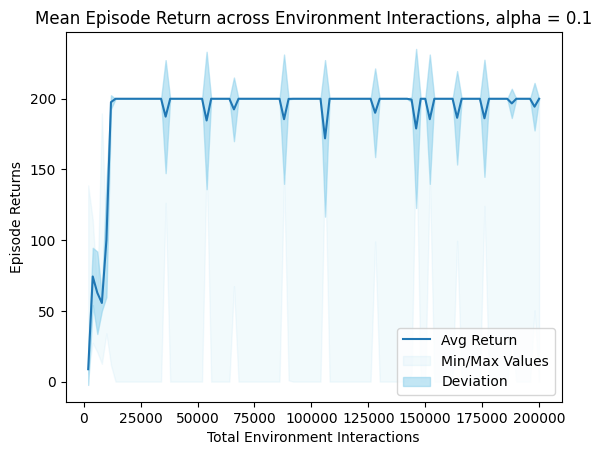

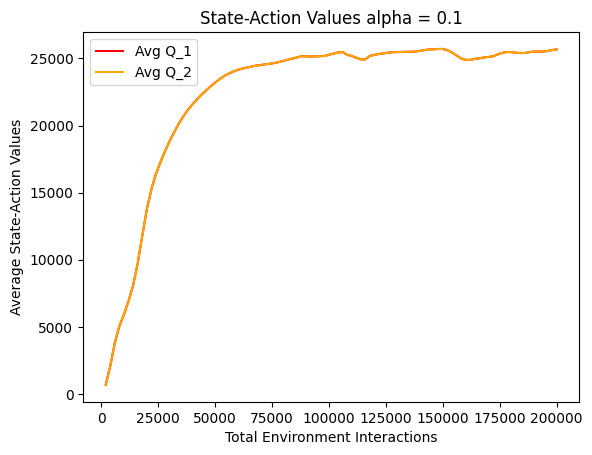

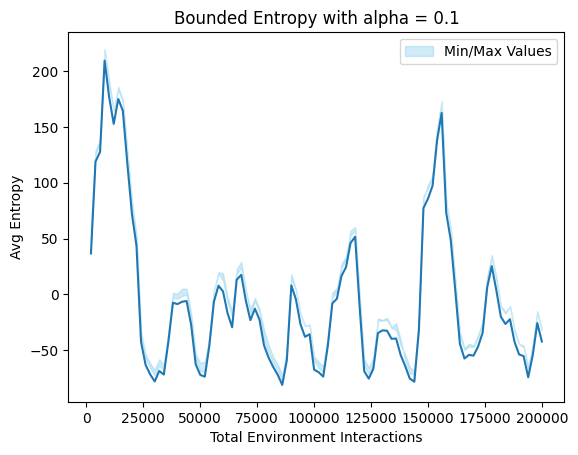

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def read_data(file_path):
    try:
        # Read the tab-separated data into a pandas DataFrame
        data = pd.read_csv(file_path, sep='\t')
        return data
    except Exception as e:
        print(f"Error reading data: {str(e)}")
        return None
    
def store_data_np(data):
    try:
        # Extract each column and convert it to a NumPy array
        columns = data.columns
        arrays = [data[col].values for col in columns]
        return arrays
    except Exception as e:
        print(f"Error extracting columns: {str(e)}")
        return None

file_path = "./logger_out_alpha_0.1/progress.txt"
data = read_data(file_path)

array_list = store_data_np(data)
avg_ep_ret = array_list[0]
std_ep_ret = array_list[1]
max_ep_ret = array_list[2]
min_ep_ret = array_list[3]

avg_test_ep_ret = array_list[4]
std_test_ep_ret = array_list[5]

avg_q1 = array_list[11]
avg_q2 = array_list[15]

avg_entropy = array_list[19]
max_entropy = array_list[21]
min_entropy = array_list[22]

total_env_reacts = array_list[10]

time = array_list[-1]

plt.plot(total_env_reacts,avg_ep_ret,label="Avg Return")
plt.fill_between(total_env_reacts,avg_ep_ret - min_ep_ret,avg_ep_ret + 200 - max_ep_ret,alpha = 0.1, color='skyblue', label = 'Min/Max Values')
plt.fill_between(total_env_reacts, avg_ep_ret - std_ep_ret,avg_ep_ret+std_ep_ret, alpha = 0.5, color='skyblue', label="Deviation")

plt.xlabel("Total Environment Interactions")
plt.ylabel("Episode Returns")
plt.title('Mean Episode Return across Environment Interactions, alpha = 0.1')
plt.legend()
plt.show()

plt.plot(total_env_reacts,avg_q1,label="Avg Q_1",color = 'red')
plt.plot(total_env_reacts,avg_q2,label = "Avg Q_2",color = "orange")
plt.xlabel("Total Environment Interactions")
plt.ylabel("Average State-Action Values")
plt.title('State-Action Values alpha = 0.1')
plt.legend()
plt.show()

plt.plot(total_env_reacts,avg_entropy)
plt.fill_between(total_env_reacts,avg_entropy-min_entropy,avg_entropy+max_entropy,alpha = 0.4, color='skyblue', label = 'Min/Max Values')

plt.xlabel("Total Environment Interactions")
plt.ylabel("Avg Entropy")
plt.title('Bounded Entropy with alpha = 0.1')
plt.legend()
plt.show()

# for col, array in zip(data.columns, array_list):
#             print(f"{col}: {array}")

Now with an $\alpha$ value set to 0.1, we do not perform much to any exploration and instead start exploiting rewards much more aggresively. As expected we can see that the training values for these stay much more constant, as we rarely explore new actions. This is highlighted in the mean episode return plots where we are hitting the max reward nearly immediately and don't drift from it through small variance of actions. 

Finally, with training complete, we can have a look at how our pendulum acts with the RL-based controller, at two various $\alpha$ values. We use the gym_test_model.py file to do this and record and present a video of the results. 

```
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def run_model(model, env, episodes, print_reward):
    """Runs the given model on the provided Gym environment."""
    act_limit = env.action_space.high[0]
    reward_arr = np.zeros(1001)
    reward_sum_arr = np.zeros(1001)
    
    for i_episode in range(episodes):
        observation = env.reset()[0]
        done = False
        step_num = 0
        reward_sum = 0

        print(f'Starting episode #{i_episode}')

        while not done:
            env.render()

            if print_reward:
                print(f'timestep: {step_num}, reward = {reward_sum}')

            action = model(tf.expand_dims(observation, 0))[0][0]
            action = tf.clip_by_value(action, -act_limit, act_limit)

            observation, reward, done, trunc, _ = env.step(action)
            done = done or trunc
            step_num += 1
            reward_sum += reward
            reward_arr[step_num] = reward
            reward_sum_arr[step_num] = reward_sum

        print(f'Episode finished after {step_num} timesteps')

    env.close()
    return reward_arr, reward_sum_arr

if __name__ == '__main__':
    print_reward = False

    agent = tf.keras.models.load_model('./model_out')
    agent.summary()

    env = gym.make("InvertedPendulum-v4",render_mode = 'human')

    rewards,reward_sum = run_model(agent, env, 1, print_reward)

    # Create subplots with two rows and one column
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot on the first row
    axs[0].plot(rewards, label='Reward', color='blue')
    axs[0].set_title('Reward each Time Step')
    axs[0].legend()

    # Plot on the second row
    axs[1].plot(reward_sum, label='Sum of Rewards', color='orange')
    axs[1].set_title('Sum of Rewards over time')
    axs[1].legend()

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.savefig('figs/trained_model.pdf')
    # Show the plot
    plt.show()
```

### Model Verification with $\alpha = 0.2$ 

In [18]:
HTML("""
<center>
    <video width="720" height="540" controls>
        <source src="vids/trained_alpha02.mp4" type="video/mp4">
    </video>
</center>
""")

From the video, we can see that our implementation was succesful, with the pendulum staying up for the entire simulation time of 1000 time steps. We see it immediately stabilizes, and stays at this position due to it constantly receiving +1 of reward. Moreover, the cart does not wander that much with it staying relatively in the same place. We can try comparing it with the $alpha = 0.1$ model now.

### Model Verification with $\alpha = 0.1$

In [19]:
HTML("""
<center>
    <video width="720" height="540" controls>
        <source src="vids/trained_alpha01.mp4" type="video/mp4">
    </video>
</center>
""")

For $\alpha = 0.1$ it is difficult to say convincingly whether or not this model is better. At the beginning it seems to accelerate much faster to the right, however it corrects for this really well as it slowly brings the cart back to the center. If we had the goal of keeping the cart in the middle, maybe we'd prefer the original implementation, however we did not include staying in the middle as part of our reward function, so this would be an unfair preference. From the plot below, we can see that each controller was able to maximize the return value over the course of 1000 time steps, implying that despite the changes in $\alpha$ both controllers were still very successful. It's possible that, upon having explored more with a larger $\alpha$, we could assume that the 0.2 value may be a more robust controller having experienced more varied actions, however that aspect was not able to be investigated due to time. With this in mind, we can't concisely determine which controller is better, however we can agree that despite tuning various parameters, the RL controller was still very successful in controlling the pendulum system. 

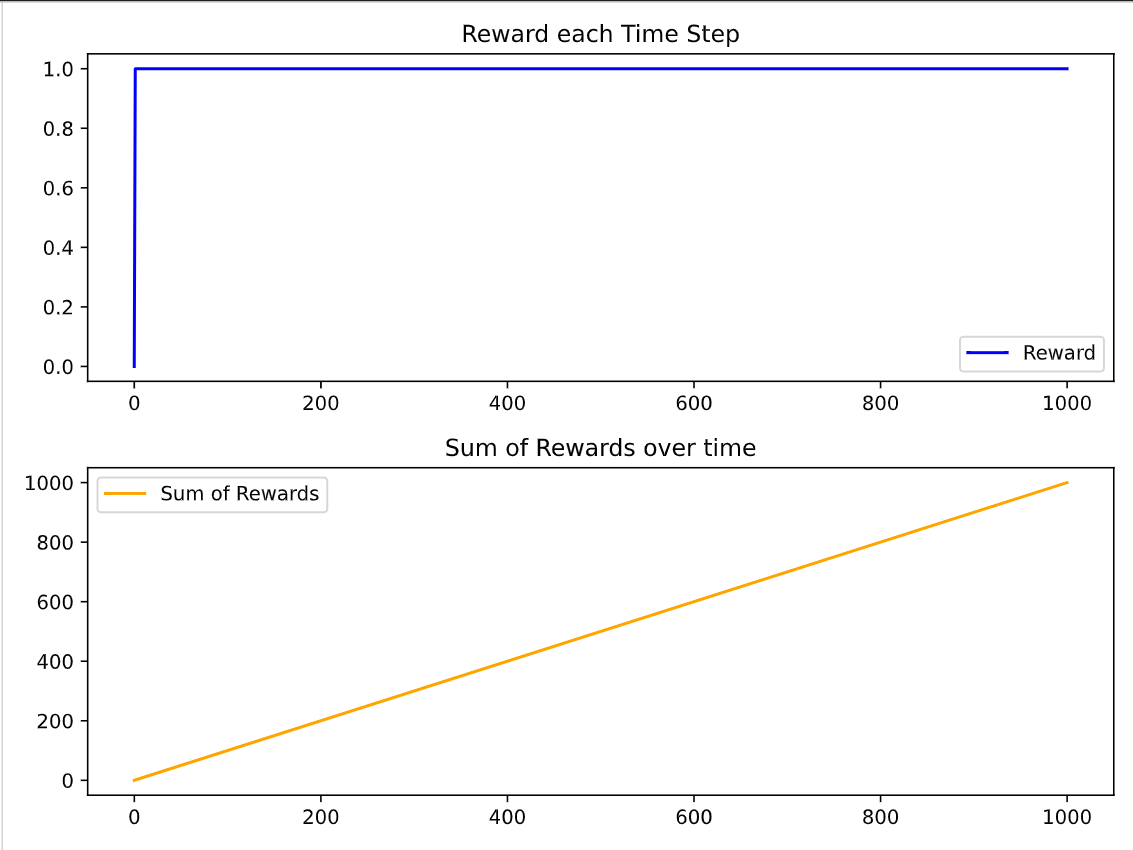

In [20]:
Image(filename = 'figs/trained_model.PNG')

## Conclusion

To conclude, this project was able to show that without any modelling of the pendulum's dynamics, RL was able to achieve stable balancing. We investigated how the SAC algorithm is well suited for continuous space problems and how it balances exploration of the space with exploitation of the learned policy. We also explored th effect of the regularization coefficient on the controller's training and performance, with an $\alpha=0.1$ having better training values, but slightly worse performance upon testing. Despite differences in the coefficients, I believe the SAC was able to perform well as the action space was relatively small with only one motor to control on a scale of -3 to 3 N. It's for this reason that success was found quite immediately, despite such a small value for the entropy regularization coefficient $\alpha$. With this we can definitively say that RL is a powerful method for controller design, especially for complex systems. However, more work needs to be done in evaluating its robustness to external disturbances, and its transfer to a real system. 

There were many struggles in getting all simulation software to work, along with coding the SAC algorithm. However if given more time I would have loved to investigate how SAC could perform "swing-up" actions given a different set of initial conditions, or if it was capable of rejecting external force disturbances similar to model-based control techniques. Moreover, exploring more complex continuous control problems where the controller is tasked to control multiple motors would be interesting to experiment with to understand what value of $\alpha$ would accompany said environments. I would assume $\alpha$ would increase in order to better explore the space of actions with multiple motors.  

## References

[1]
M. Towers et al., ‘Gymnasium’. Zenodo, Mar-2023.

[2]
F. Foundation, ‘Gymnasium documentation’, Inverted Pendulum - Gymnasium Documentation. Farama Foundation.

[3]
J. Achiam, ‘Soft actor-critic’, Soft Actor-Critic - Spinning Up documentation. OpenAI.

[4]
T. Haarnoja, A. Zhou, P. Abbeel, and S. Levine, ‘Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor’, CoRR, vol. abs/1801.01290, 2018.

[5]
S. Fujimoto, H. van Hoof, and D. Meger, ‘Addressing Function Approximation Error in Actor-Critic Methods’, CoRR, vol. abs/1802.09477, 2018.